# Introduction

This notebook consists of seven main sections:
* 0) Setup
    * Basic notebook setup.
* 1) A refactoring/collection of other notebooks
    * We tried to make the code more understandable and extracted many feature-engineered attributes and useful functions from this notebook.
* 2) SVD-Based classification and experiments
    * Here we do some more feature engineering and make a simple classifier based on a few of the extracted vectors. The result of this classifier will be later passed as an attribute to the final classifier.
* 3) Cascading classifiers - Original features
    * Here we combine the attributes extracted from the first notebook and the results from the SVD classifier.
* 4) Cascading classifiers - SVD + Atemporal features + Temporal features
    * Here we experiment with separating the classifiers even further (we called this approach "divide et impera"), fitting models on features directly related to time (called "temporal" from now on) and those not directly related to time (called "atemporal" from now on) separately and then combining them in a cascading classifier. This test is mostly exploratory, but we expect it to allow each classifier to pick up on subtler patterns within their domains.
* 5) Cascading classifiers - Frankenstein's monster
    * After not achieving much better results, we decided to make a final classifier that has access to every feature we generated so far (SVD vectors, SVD classifier result, Temporal classifier result, Atemporal classifier result and our original features). Once again, this test is mostly exploratory.
* 6) Conclusion and analysis

# Section 0 - Setup

Here we import the needed libraries and load our datasets.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import gc
from pathlib import Path
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('../'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# copy-paste
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
import warnings
import math
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [2]:
%%time
PATH = Path('../input/elo-merchant-category-recommendation')
df_train = pd.read_csv(PATH/'train.csv', parse_dates=['first_active_month']);
df_test = pd.read_csv(PATH/'test.csv', parse_dates=['first_active_month']);

CPU times: user 459 ms, sys: 59.3 ms, total: 518 ms
Wall time: 543 ms


In [3]:
%%time
df_hist_trans = pd.read_csv(PATH/'historical_transactions.csv', parse_dates=['purchase_date']);
df_new_merch_trans = pd.read_csv(PATH/'new_merchant_transactions.csv', parse_dates=['purchase_date']);

CPU times: user 1min 29s, sys: 13 s, total: 1min 42s
Wall time: 1min 42s


# Section I - Refactoring

We analysed some existing notebooks to understand how people were approaching the problem so far.

This section consists in a collection of interesting and useful snippets taken from those notebooks.

These cells were extracted from the following sources:

1) [my-first-kernel](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699) by [chauhuynh](https://www.kaggle.com/chauhuynh).

2) [elo-world](https://www.kaggle.com/fabiendaniel/elo-world) by [fabiendaniel](https://www.kaggle.com/fabiendaniel)

## Memory-saving function

This function scans datasets for potential type changes that could save memory. This considerably reduces our dataset's memory consumption.

In [4]:
# https://www.kaggle.com/fabiendaniel/elo-world
def reduce_mem_usage(df, verbose=True):
    prefixes = ['int', 'float']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = str(df[col].dtype)
        if not col_type.startswith('int') and not col_type.startswith('float'):
#             print('col_type:', col_type, 'not compressed')
            continue
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type.startswith('int'):
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)  
        elif col_type.startswith('float'):
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)    
    if verbose:
        end_mem = df.memory_usage().sum() / 1024**2
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/
# Same logic
def fillna_mode(df, cols, pipeline=False):
    for c in cols:
        df[c].fillna(df[c].mode()[0], inplace=True)
    return df if pipeline else None


def get_nan_col_names(df: pd.DataFrame, df_name='<not named>'):
    total = df.shape[0]
    missing_cols = []
    for c in df.columns:
        quo = (total - pd.notna(df[c]).sum())/total
        if quo != 0:
            missing_cols.append(c)
    print(df_name, 'MISSING COLS:', missing_cols)
    return missing_cols

In [5]:
reduce_mem_usage(df_train);
reduce_mem_usage(df_test);
reduce_mem_usage(df_hist_trans);
reduce_mem_usage(df_new_merch_trans);

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


## Time and date-related feature functions

These functions will be used to generate extra features based on the date data we have.

In [6]:
#https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
def add_month_diff(df, pipeline=False):
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days) // 30
    df['month_diff'] += df['month_lag']
    return df if pipeline else None


# https://www.kaggle.com/chauhuynh/my-first-kernel-3-699
def pre_process_trans(df, date_col, date_formated=False, add_month=True):
    fillna_mode(df, cols=get_nan_col_names(df))
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0}).astype(np.int8)
    df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0}).astype(np.int8)    
    df['category_2'] = df['category_2'].astype(np.int8)

    if not date_formated:
        df[date_col] = pd.to_datetime(df[date_col])
    df['year'] = df[date_col].dt.year
    df['weekofyear'] = df[date_col].dt.weekofyear
    df['month'] = df[date_col].dt.month
    df['dayofweek'] = df[date_col].dt.dayofweek
    df['weekend'] = (df[date_col].dt.weekday >= 5).astype(np.int8)
    df['hour'] = df[date_col].dt.hour
    if add_month:
        add_month_diff(df)


# https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]


# Refactor of https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/
def custom_group_by(df: pd.DataFrame, df_name: str, agg_by: dict):
    for col in ['category_2','category_3']:
        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        aggs[col+'_mean'] = ['mean']    
    new_columns = get_new_columns(df_name, agg_by)
#     print("new_columns: \n", *new_columns, sep='\t\n')
    df_group = df.groupby('card_id').agg(agg_by)
    df_group.columns = new_columns
    df_group.reset_index(drop=False, inplace=True)
    df_group[df_name + '_purchase_date_diff'] = (
        df_group[df_name + '_purchase_date_max']
            - df_group[df_name + '_purchase_date_min']
        ).dt.days
    df_group[df_name + '_purchase_date_average'] = (
        df_group[df_name + '_purchase_date_diff']
            / df_group[df_name + '_card_id_size']
        )
    df_group[df_name + '_purchase_date_uptonow'] = (
        datetime.datetime.today()
        - df_group[df_name + '_purchase_date_max']
        ).dt.days

    return df_group

## Feature-engineered attributes
These attributes were extracted from the following source:
1. [my-first-kernel][mfk]

[mfk]: https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/comments

In [7]:
aggs = {}

# Count number of unique values at each column.
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ('nunique',)


aggs['purchase_amount'] = ('sum','max','min','mean','var')
aggs['installments'] = ('sum','max','min','mean','var')

# purchase range
aggs['purchase_date'] = ('max','min')

aggs['month_lag'] = ('max','min','mean','var')
aggs['month_diff'] = ('mean',)

# How many transactions:
# - were on the weekend, and the percentage
# - has category_1 as 1 (binary feature), and the percentage
# - were authorized, and its percentage

aggs['weekend'] = ('sum', 'mean')
aggs['category_1'] = ('sum', 'mean')
aggs['authorized_flag'] = ('sum', 'mean')

# How many purchases each card did?
aggs['card_id'] = ('size', )

In [8]:
_old_train = df_train.copy()
_odl_test = df_test.copy()

In [9]:
%%time
gps = []
for name, df in [('hist', df_hist_trans), ('new_hist', df_new_merch_trans)]:    
    pre_process_trans(df, date_col='purchase_date')
    df_group = custom_group_by(df, name, aggs.copy())
    gps.append(df_group)
    df_train = df_train.merge(df_group, on='card_id', how='left')
    df_test = df_test.merge(df_group, on='card_id', how='left')


<not named> MISSING COLS: ['category_3', 'merchant_id', 'category_2']
<not named> MISSING COLS: ['category_3', 'merchant_id', 'category_2']
CPU times: user 3min 11s, sys: 1.92 s, total: 3min 13s
Wall time: 3min 13s


In [10]:
prob = [
    'hist_purchase_date_max',
    'hist_purchase_date_min',
    'new_hist_purchase_date_max',
    'new_hist_purchase_date_min',
]

def post_process_df(df):
    global prob
    
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['fam_dayofweek'] = df['first_active_month'].dt.dayofweek
    df['fam_weekofyear'] = df['first_active_month'].dt.weekofyear
    df['fam_month'] = df['first_active_month'].dt.month
    df['fam_elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days

    df[prob[:2]] = df[prob[:2]].astype(np.int64) * 1e-9

    
    df['transactions_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

    for f in ['feature_1','feature_2','feature_3']:
        order_label = df_train.groupby([f])['outliers'].mean()
        df_train[f] = df_train[f].map(order_label)
        df_test[f] = df_test[f].map(order_label)
    

In [11]:
print(df_train.hist_purchase_date_max.notna().sum())
print(df_train.hist_purchase_date_min.notna().sum())
print(df_train.new_hist_purchase_date_max.notna().sum())
print(df_train.new_hist_purchase_date_min.notna().sum())

201917
201917
179986
179986


In [12]:
df_train['outliers'] = (df_train.target < -30).astype(np.int8)

In [13]:
post_process_df(df_train)
post_process_df(df_test)

In [14]:
df_test.drop(['new_hist_purchase_date_max', 'new_hist_purchase_date_min'], axis=1,inplace=True)
df_train.drop(['new_hist_purchase_date_max', 'new_hist_purchase_date_min'], axis=1,inplace=True)

## Meta-paremeters for the models

The following function fits an LGB model to a dataset `ds` with target `ds_ta` and test dataset `ds_te` with the num_leaves parameter set to `num_leaves`. The metaparameters were compiled from the notebooks and the two values for `num_leaves` uses in this notebook were found via trial-and-error.

In [15]:
def LGB_Train(df_train,df_test,target,num_leaves):
    param = {'num_leaves': num_leaves,
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590}
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
    oof = np.zeros(len(df_train))
    predictions_train = np.zeros(len(df_train)) 
    predictions_test = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month', 'outliers', 'target']]

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = df_train_columns
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions_test += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits
        predictions_train += clf.predict(df_train[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

    return {'predictions_test':predictions_test,'predictions_train':predictions_train,'feature_importances':feature_importance_df}
    

# Section II - SVD

In this section we'll be using Singular Value Decomposition for both assisting the classifiers and trying to better understand the relationships between some of the numerical attributes.

## Calculation and analysis

Firstly, we compute the decomposition and try analysing some of its results.

In [16]:
#A dataframe containing only numerical values
df_num=df_train[[col for col in df_train.columns if not col in ['target','outliers']]].select_dtypes(include='number')

#NaN/Missing values will be replaced with zeroes
# df_num.fillna(0,inplace=True)
fillna_mode(df_num, df_num.columns)


decomp = TruncatedSVD(n_components=len(df_num.columns.values)-1,random_state=1)
decomp.fit(df_num)

TruncatedSVD(algorithm='randomized', n_components=80, n_iter=5, random_state=1,
             tol=0.0)

We intend to select the most descriptive vectors, that is, the ones across which the data points spreads the most.

Let's plot their eigenvalues.

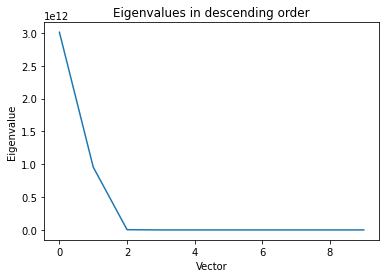

[Text(0, 0.5, 'Eigenvalue'), Text(0.5, 0, 'Vector')]

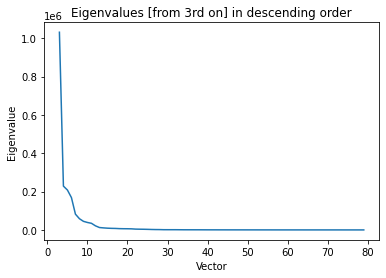

In [17]:
plot=sns.lineplot(x=range(10),y=decomp.singular_values_[:10])
plot.set_title("Eigenvalues in descending order")
plot.set(ylabel="Eigenvalue",xlabel="Vector")
plt.show()
plot=sns.lineplot(x=range(3,len(decomp.singular_values_)),y=decomp.singular_values_[3:])
plot.set_title("Eigenvalues [from 3rd on] in descending order")
plot.set(ylabel="Eigenvalue",xlabel="Vector")

The first few vectors clearly represent much of the information contained here. This is a good sign.

The following plot illustrates the squared weights of each numerical feature for projecting onto the first 10 component vectors (for estimating the importance of each attribute on the projection).

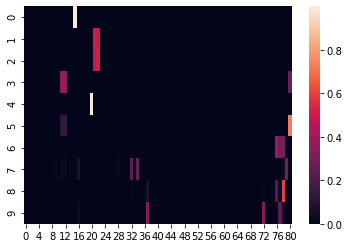

In [18]:
sns.heatmap([[x**2 for x in component] for component in decomp.components_[:10]])

Some attributes consistently have more weight than others. Let's figure out which exactly are those.

The following graphs show the squared weight of each of the 3 most important attributes for the first 3 vectors.

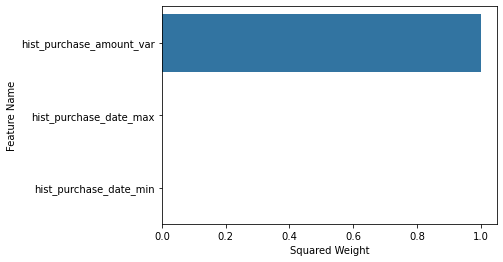

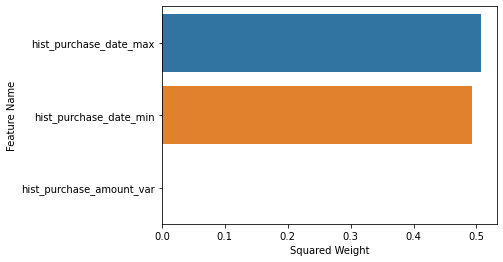

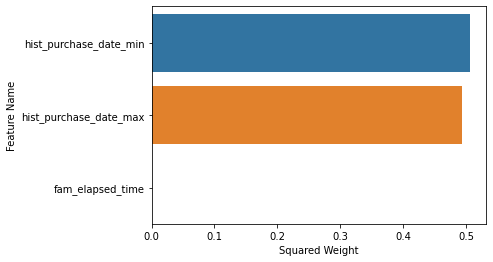

In [19]:
for component in decomp.components_[:3]:
    weights=sorted(zip([x**2 for x in component],df_num.columns.values),reverse=True)[:3]
    sns.barplot(data=pd.DataFrame(weights,columns=['Squared Weight','Feature Name']),y='Feature Name',x='Squared Weight')
    plt.show()

It appears that the most descriptive features are consistently the **purchase date** and **expenditure**. This might make sense intuitively, but let's try not to let it bias our interpretation.

Let's figure out how many of the resulting vectors we should pass to the classifier.

This analysis is mostly just exploratory. We don't have much basis for actually justifying these specific choices and experiments beforehand (beyond quasi-scientifical intuition).

We arbitrarily chose to 'keep 80% of the information' (keep the vectors whose eigenvalues sum up to 80% of the total sum). This is a standard limit used when applying this kind of decomposition in images and its  effectiveness is visible (pun unintended) on those cases. We hope this concept translates well to this specific situation.

For achieving that, we'll be keeping the following number of vectors:

In [20]:
for num_vectors in range(1,len(decomp.singular_values_)):
    acc_ratio=sum(decomp.singular_values_[:num_vectors])/sum(decomp.singular_values_)
    if (sum(decomp.singular_values_[:num_vectors])/sum(decomp.singular_values_))>=0.80:
            break;
print(str(num_vectors)+" ("+str(round(acc_ratio*10000)/100)+"%)")

2 (99.92%)


> Sidenote: the first two vectors account for 99.92% of the accumulated eigenvalues. This looks promising.

For the record, here's a plot of the accumulated squared weights of each attribute for the vectors that will be used.

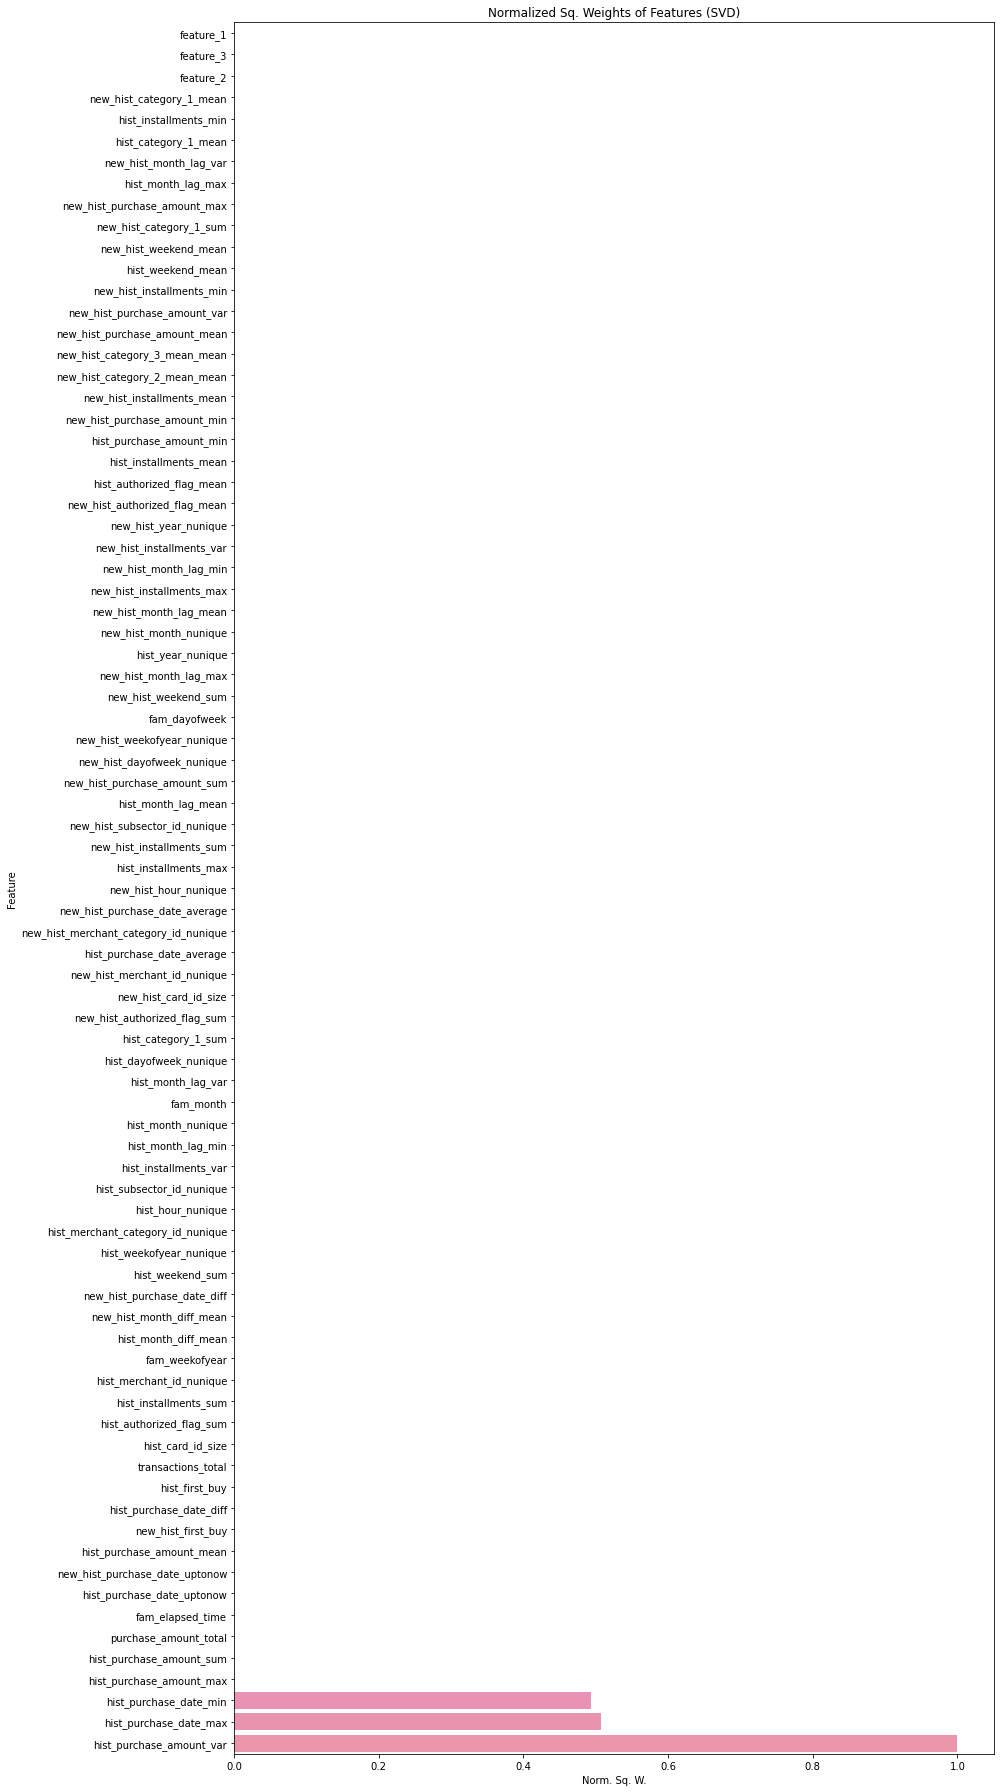

In [21]:
sq_eigenval=dict(zip(df_num.columns.values,[0 for i in range(len(df_num.columns.values))]))
for component in decomp.components_[:num_vectors]:
    weights=zip([x**2 for x in component],df_num.columns.values)
    for line in weights:
        sq_eigenval[line[1]]+=line[0] if not np.isnan(line[0]) else 0

#Normalization
sq_eigenval=pd.DataFrame(sq_eigenval.items(),columns=['Feature','Sq. Weight']).sort_values(by='Sq. Weight')
sq_eigenval['Norm. Sq. W.']=(sq_eigenval['Sq. Weight']-sq_eigenval['Sq. Weight'].min())/(sq_eigenval['Sq. Weight'].max()-sq_eigenval['Sq. Weight'].min())

plt.figure(figsize=(14,25))
sns.barplot(
            y='Feature',
            x='Norm. Sq. W.',
            data=sq_eigenval
)
plt.title('Normalized Sq. Weights of Features (SVD)')
plt.tight_layout()
plt.savefig('svd_importances.png')

We should now generate our `training` and `testing` sets for the SVD classifier.

In [22]:
df_num=df_train[[col for col in df_train.columns if not col in ['target','outliers']]].select_dtypes(include='number')
# df_num.fillna(0,inplace=True)
fillna_mode(df_num, df_num.columns)

df_svd_train=pd.DataFrame([x[:num_vectors]for x in decomp.transform(df_num)],columns=['svd_'+str(i) for i in range(num_vectors)])
#df_train_svd=df_train.join(df_svd,lsuffix='_caller', rsuffix='_other')
df_svd_train['target']=df_train['target']
df_svd_train['outliers']=df_train['outliers']

df_num=pd.DataFrame(data=df_test,columns=df_num.columns.values)
# df_num.fillna(0,inplace=True)
fillna_mode(df_num, df_num.columns)


df_svd_test=pd.DataFrame([x[:num_vectors]for x in decomp.transform(df_num)],columns=['svd_'+str(i) for i in range(num_vectors)])
#df_test_svd=df_test.join(df_svd,lsuffix='_caller', rsuffix='_other')
print("Datasets generated.")

Datasets generated.


Before trying to do any classification, let's project our data using the first two vectors and see if any simple visible pattern arises.

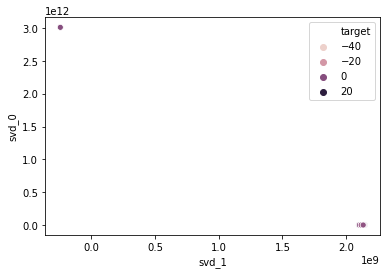

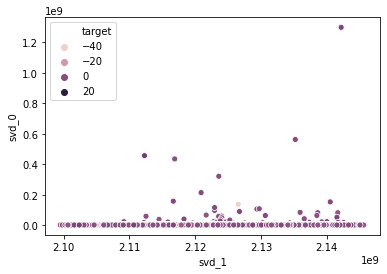

In [23]:
sns.scatterplot(data=df_svd_train,x='svd_1',y='svd_0',hue='target')
plt.show()
sns.scatterplot(data=df_svd_train.query('svd_1>0'),x='svd_1',y='svd_0',hue='target')

This looks nothing like we'd expect from an SVD. The vectors still have huge eigenvalues, though, so we must be onto something.

Let's just give that to the classifiers.

In [24]:
target=df_svd_train['target']
del df_svd_train['target']

In [25]:
%%time
results=LGB_Train(df_svd_train,df_svd_test,target,5)
predictions_train_svd=results['predictions_train']
predictions_test_svd=results['predictions_test']

fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.82433	valid_1's rmse: 3.82202
[200]	training's rmse: 3.82019	valid_1's rmse: 3.81821
[300]	training's rmse: 3.81913	valid_1's rmse: 3.81747
[400]	training's rmse: 3.81862	valid_1's rmse: 3.81715
[500]	training's rmse: 3.81825	valid_1's rmse: 3.81698
[600]	training's rmse: 3.81795	valid_1's rmse: 3.8169
[700]	training's rmse: 3.81768	valid_1's rmse: 3.81684
[800]	training's rmse: 3.81745	valid_1's rmse: 3.81678
[900]	training's rmse: 3.81724	valid_1's rmse: 3.81681
Early stopping, best iteration is:
[807]	training's rmse: 3.81743	valid_1's rmse: 3.81677
fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.82329	valid_1's rmse: 3.82671
[200]	training's rmse: 3.81923	valid_1's rmse: 3.82214
[300]	training's rmse: 3.81819	valid_1's rmse: 3.82108
[400]	training's rmse: 3.81765	valid_1's rmse: 3.82071
[500]	training's rmse: 3.81727	valid_1's rmse: 3.82055
[60

Ok. Now that we've finished classifying, we may use the predictions as an attribute for our next classifier.

# Section III - Cascading Classifiers (Original features)

We'll first integrate the results of our classifiers into our training and testing sets.

In [26]:
df_train['svd_prediction']=predictions_train_svd
df_test['svd_prediction']=predictions_test_svd

df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month', 'outliers', 'target']]
target = df_train['target']
del df_train['target']

Then we fit another Light Gradient Boosting model to our new training set.

In [27]:
%%time
results=LGB_Train(df_train,df_test,target,31)
feature_importance_df=results['feature_importances']
predictions_brute=results['predictions_test']

fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.66081	valid_1's rmse: 3.72971
[200]	training's rmse: 3.58278	valid_1's rmse: 3.70402
[300]	training's rmse: 3.53553	valid_1's rmse: 3.69249
[400]	training's rmse: 3.49943	valid_1's rmse: 3.68645
[500]	training's rmse: 3.46809	valid_1's rmse: 3.68242
[600]	training's rmse: 3.44209	valid_1's rmse: 3.68006
[700]	training's rmse: 3.41919	valid_1's rmse: 3.67924
[800]	training's rmse: 3.39816	valid_1's rmse: 3.67843
[900]	training's rmse: 3.37848	valid_1's rmse: 3.67788
Early stopping, best iteration is:
[884]	training's rmse: 3.38153	valid_1's rmse: 3.67767
fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.66333	valid_1's rmse: 3.72249
[200]	training's rmse: 3.58573	valid_1's rmse: 3.69284
[300]	training's rmse: 3.53918	valid_1's rmse: 3.68055
[400]	training's rmse: 3.50314	valid_1's rmse: 3.67264
[500]	training's rmse: 3.47327	valid_1's rmse: 3.66821
[6

After fitting, we can compare the importance of each feature with a bar plot.

> Sidenote: The svd_classifier feature seems to have a high importance, providing us with a good justification for using this cascading method.

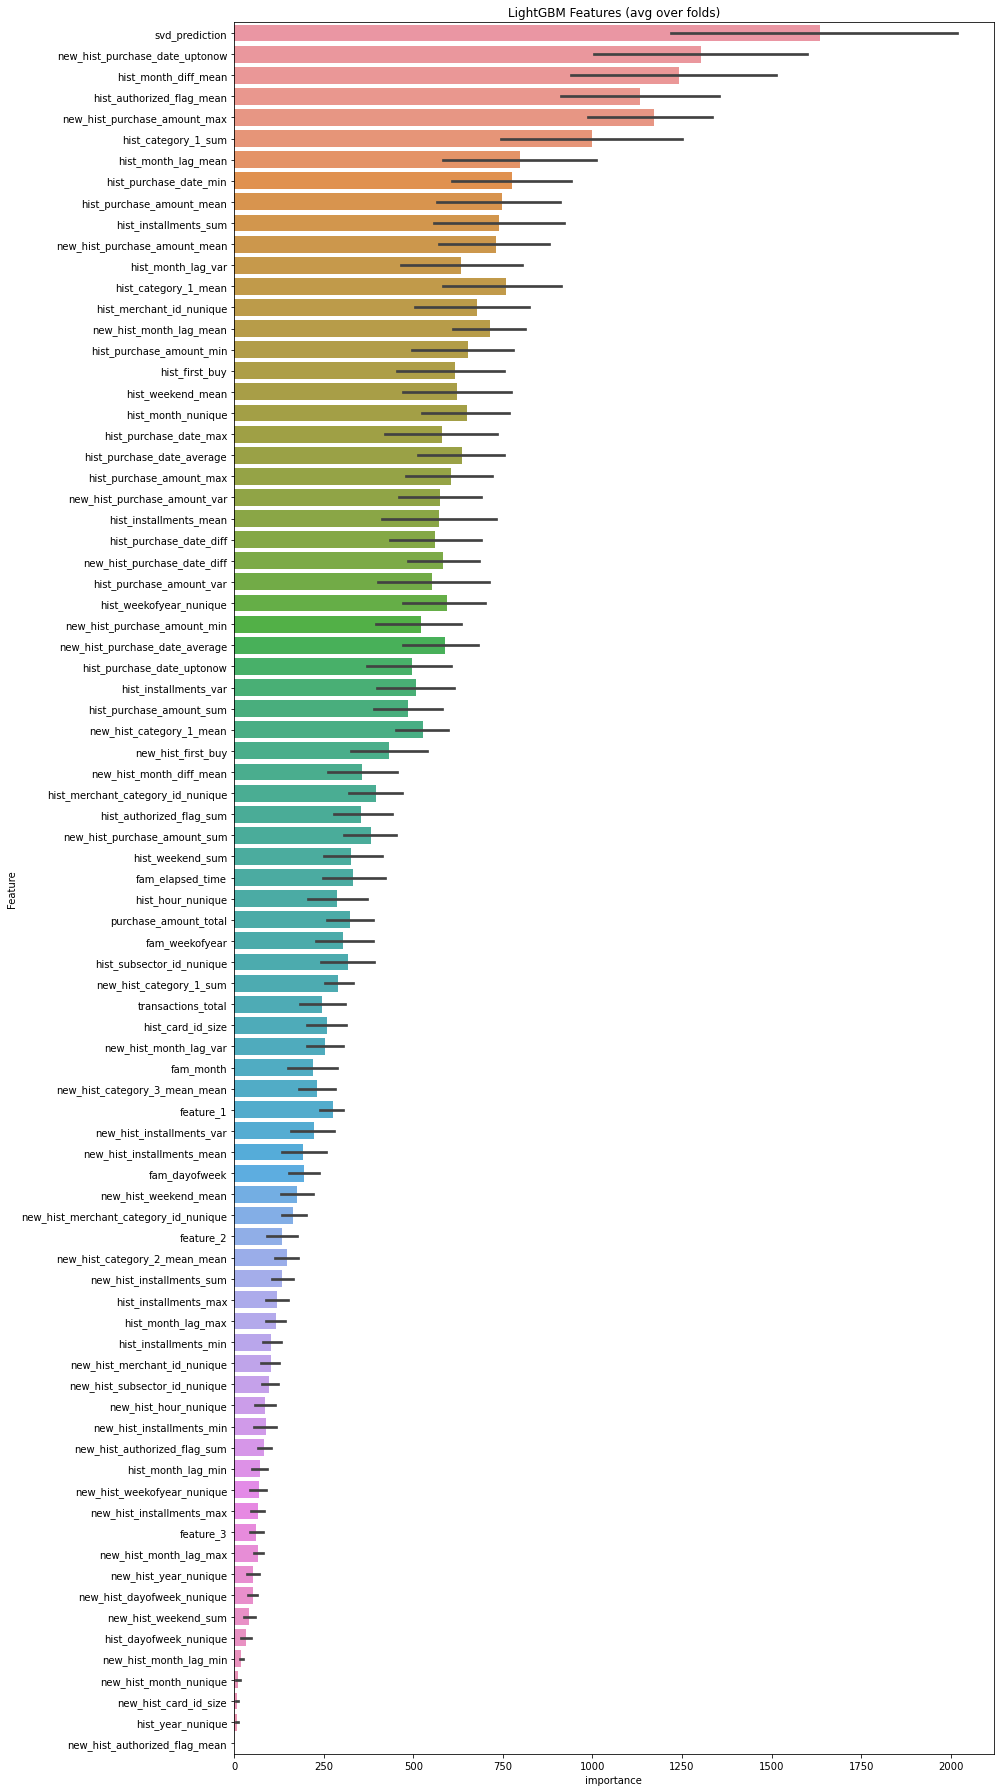

In [28]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

# Section IV - Cascading classifiers (Divide et impera)

This approach will be slightly more complex than what we have tried so far. We'll be generating 4 different classifiers, divided in two layers:
* Layer 1 - Three LGB classifiers, each based on either SVD, "temporal" or "atemporal" features only.
* Layer 2 - One LGB classifier that receives the predictions of the previous layer and generates its own prediction, which will be our final guess.

The following illustration may help understanding it more clearly:

![Illustration](https://i.imgur.com/O6MOofk.png)

Firstly, we'll separate the training set into two separate sets: `temporal` and `atemporal` (the SVD-based prediction has already been made and is stored in the 'svd_prediction' column).

In [29]:
temporal_features=[c for c in df_train.columns if (("week" in c) or ("day" in c) or ("date" in c) or ("year" in c))]
df_train_temporal = df_train[temporal_features]
df_test_temporal = df_test[temporal_features]
df_train_temporal['outliers']=df_train['outliers']
df_train_atemporal = df_train[[c for c in df_train.columns if c not in temporal_features]]
df_test_atemporal = df_test[[c for c in df_test.columns if c not in temporal_features]]
df_train_atemporal['outliers']=df_train['outliers']

Then we fit each model separately.

## 'Atemporal' Features

In [30]:
%%time
results=LGB_Train(df_train_atemporal,df_test_atemporal,target,31)
predictions_test_atemporal=results['predictions_test']
predictions_train_atemporal=results['predictions_train']

fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.668	valid_1's rmse: 3.72862
[200]	training's rmse: 3.5943	valid_1's rmse: 3.70334
[300]	training's rmse: 3.55071	valid_1's rmse: 3.69349
[400]	training's rmse: 3.51686	valid_1's rmse: 3.68782
[500]	training's rmse: 3.49017	valid_1's rmse: 3.6845
[600]	training's rmse: 3.46661	valid_1's rmse: 3.68183
[700]	training's rmse: 3.44593	valid_1's rmse: 3.68033
[800]	training's rmse: 3.42712	valid_1's rmse: 3.67983
[900]	training's rmse: 3.40908	valid_1's rmse: 3.67953
[1000]	training's rmse: 3.3915	valid_1's rmse: 3.67943
Early stopping, best iteration is:
[915]	training's rmse: 3.40632	valid_1's rmse: 3.67913
fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.67009	valid_1's rmse: 3.72045
[200]	training's rmse: 3.59583	valid_1's rmse: 3.69078
[300]	training's rmse: 3.55275	valid_1's rmse: 3.67923
[400]	training's rmse: 3.51968	valid_1's rmse: 3.6728
[500]	t

## 'Temporal' Features

In [31]:
%%time
results=LGB_Train(df_train_temporal,df_test_temporal,target,31)
predictions_test_temporal=results['predictions_test']
predictions_train_temporal=results['predictions_train']

fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.74218	valid_1's rmse: 3.76866
[200]	training's rmse: 3.70095	valid_1's rmse: 3.7529
[300]	training's rmse: 3.67478	valid_1's rmse: 3.74892
[400]	training's rmse: 3.65397	valid_1's rmse: 3.74709
[500]	training's rmse: 3.63691	valid_1's rmse: 3.74616
[600]	training's rmse: 3.6205	valid_1's rmse: 3.7462
Early stopping, best iteration is:
[522]	training's rmse: 3.63312	valid_1's rmse: 3.74598
fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.74147	valid_1's rmse: 3.77265
[200]	training's rmse: 3.70047	valid_1's rmse: 3.75429
[300]	training's rmse: 3.67416	valid_1's rmse: 3.74898
[400]	training's rmse: 3.65359	valid_1's rmse: 3.74691
[500]	training's rmse: 3.6366	valid_1's rmse: 3.746
[600]	training's rmse: 3.62174	valid_1's rmse: 3.74566
[700]	training's rmse: 3.60815	valid_1's rmse: 3.7448
[800]	training's rmse: 3.59458	valid_1's rmse: 3.74409
[900]	tra

## Cascading the results into the final classifier

We then generate a final training set with 3 features: `svd_prediction`, `temporal_prediction` and `atemporal_prediction` and fit another classifier.

In [32]:
df_train_impera = df_train[['svd_prediction','outliers']]
df_train_impera['temporal_prediction']=predictions_train_temporal
df_train_impera['atemporal_prediction']=predictions_train_atemporal
df_test_impera=df_test[['svd_prediction']]
df_test_impera['temporal_prediction']=predictions_test_temporal
df_test_impera['atemporal_prediction']=predictions_test_atemporal

In [33]:
%%time
results=LGB_Train(df_train_impera,df_test_impera,target,31)
feature_importance_df=results['feature_importances']
predictions_impera=results['predictions_test']

fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.38546	valid_1's rmse: 3.43217
[200]	training's rmse: 3.29969	valid_1's rmse: 3.36503
[300]	training's rmse: 3.27095	valid_1's rmse: 3.35406
[400]	training's rmse: 3.25456	valid_1's rmse: 3.35158
[500]	training's rmse: 3.24253	valid_1's rmse: 3.35154
Early stopping, best iteration is:
[442]	training's rmse: 3.24901	valid_1's rmse: 3.35128
fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.3837	valid_1's rmse: 3.42555
[200]	training's rmse: 3.29753	valid_1's rmse: 3.36788
[300]	training's rmse: 3.26929	valid_1's rmse: 3.36044
[400]	training's rmse: 3.25258	valid_1's rmse: 3.36006
Early stopping, best iteration is:
[382]	training's rmse: 3.25512	valid_1's rmse: 3.35974
fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.39723	valid_1's rmse: 3.37343
[200]	training's rmse: 3.31204	valid_1's rmse: 3.30115
[300]	tra

Now we list the feature importances for the final classifier.

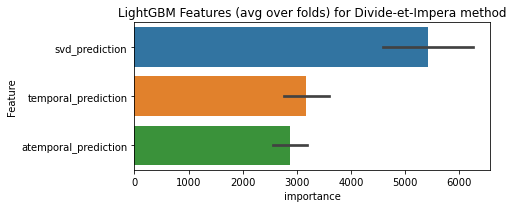

In [34]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(7,3))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds) for Divide-et-Impera method')
plt.tight_layout()
plt.savefig('lgbm_dei_importances.png')

# Section V - Cascading Classifiers (Frankenstein's monster)

In this section, we'll simply combine everything we have done so far into a single classifier and evaluate its performance. This classifier will have as its input the set of all the features we obtained plus the predictions of the first layer of the "Divide et Impera" model and the projections on the two first SVD vectors.

Firstly, we update our training dataset with the new columns we generated.

In [35]:
df_train['temporal_prediction']=predictions_train_temporal
df_train['atemporal_prediction']=predictions_train_atemporal
df_test['temporal_prediction']=predictions_test_temporal
df_test['atemporal_prediction']=predictions_test_atemporal
df_train=df_train.join(df_svd_train[[c for c in df_svd_train.columns if "svd" in c]], lsuffix='_caller', rsuffix='_other')
df_test=df_test.join(df_svd_test[[c for c in df_svd_train.columns if "svd" in c]], lsuffix='_caller', rsuffix='_other')

And then we fit our new model.

In [36]:
%%time
results=LGB_Train(df_train,df_test,target,31)
feature_importance_df=results['feature_importances']
predictions_frankie=results['predictions_test']

fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.25067	valid_1's rmse: 3.33637
[200]	training's rmse: 3.06088	valid_1's rmse: 3.19507
[300]	training's rmse: 2.96474	valid_1's rmse: 3.13516
[400]	training's rmse: 2.89803	valid_1's rmse: 3.09798
[500]	training's rmse: 2.84404	valid_1's rmse: 3.07042
[600]	training's rmse: 2.79783	valid_1's rmse: 3.04787
[700]	training's rmse: 2.75804	valid_1's rmse: 3.0288
[800]	training's rmse: 2.72313	valid_1's rmse: 3.01432
[900]	training's rmse: 2.6925	valid_1's rmse: 3.00251
[1000]	training's rmse: 2.66348	valid_1's rmse: 2.99096
[1100]	training's rmse: 2.63735	valid_1's rmse: 2.98098
[1200]	training's rmse: 2.61308	valid_1's rmse: 2.97262
[1300]	training's rmse: 2.5906	valid_1's rmse: 2.9654
[1400]	training's rmse: 2.57014	valid_1's rmse: 2.95924
[1500]	training's rmse: 2.55103	valid_1's rmse: 2.95365
[1600]	training's rmse: 2.53206	valid_1's rmse: 2.94754
[1700]	training's rmse: 2.51447	valid_1's rmse: 

And finally, we plot "Frankenstein's monster"'s feature importances.

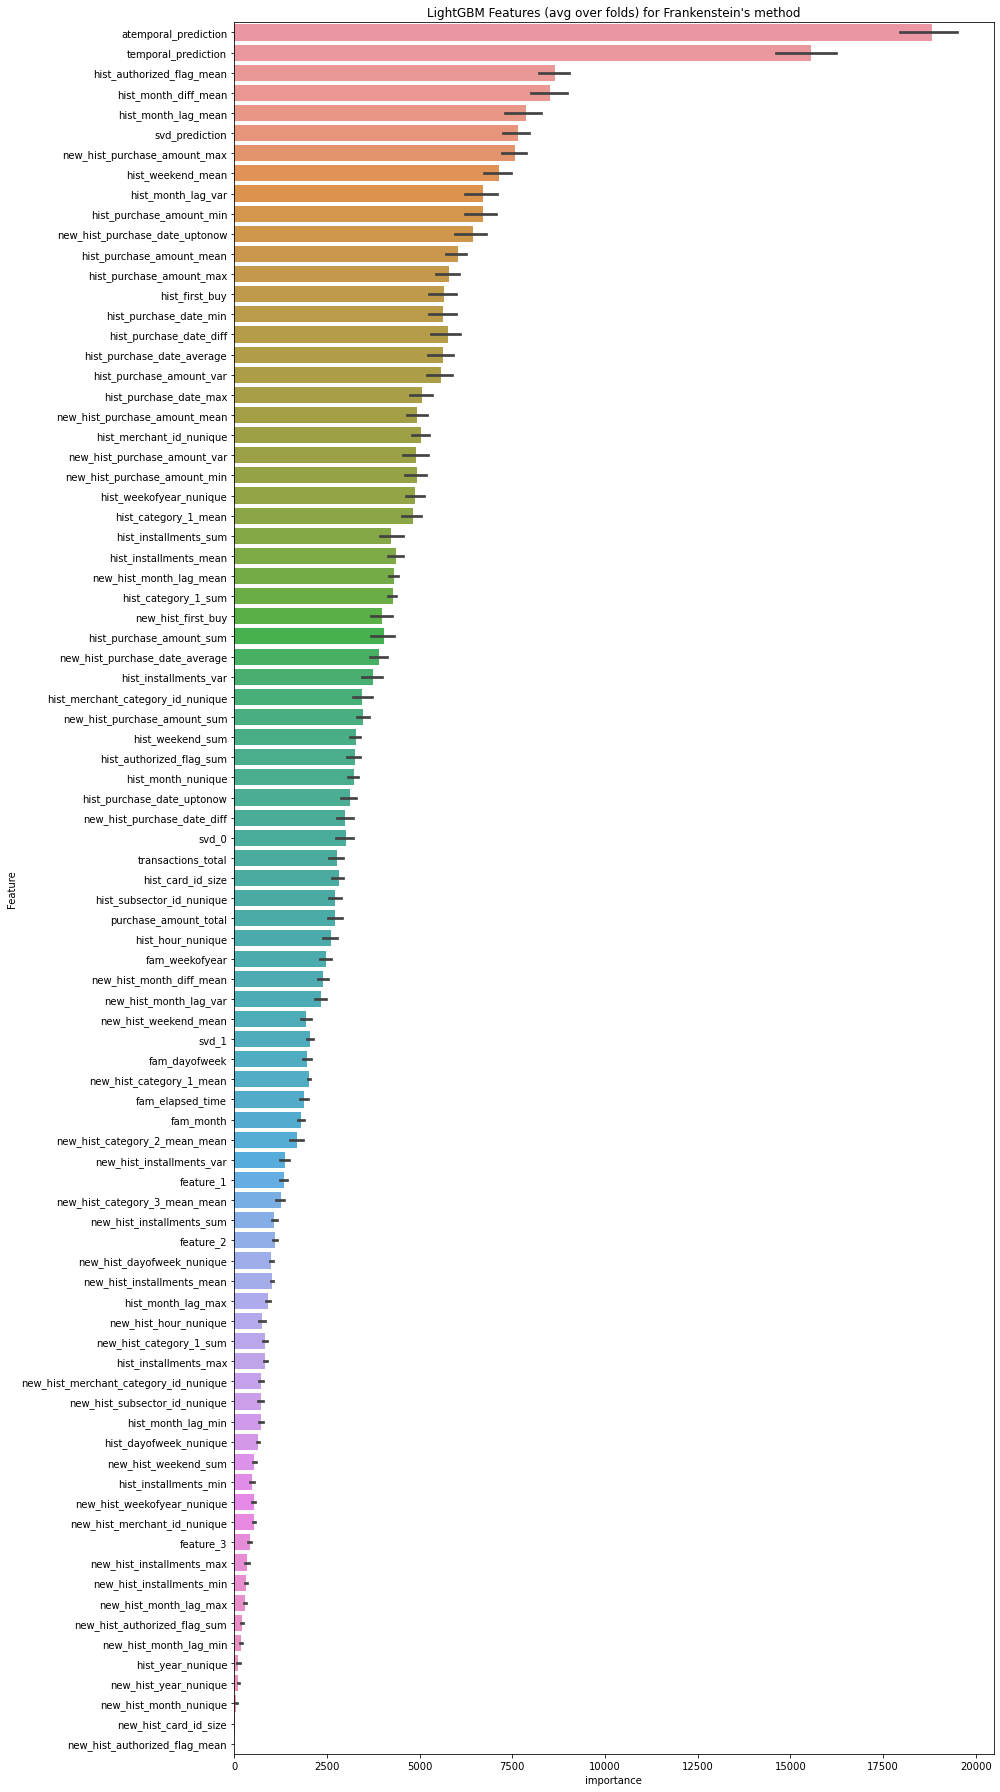

In [37]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds) for Frankenstein\'s method')
plt.tight_layout()
plt.savefig('lgbm_frankie_importances.png')

We'll submit the classifiers' results for evaluating this notebook's performance.

In [38]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions_frankie
sub_df.to_csv("submission_frankie.csv", index=False)

sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions_impera
sub_df.to_csv("submission_impera.csv", index=False)

sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions_brute
sub_df.to_csv("submission_brutus.csv", index=False)

sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions_test_atemporal
sub_df.to_csv("submission_atemporal.csv", index=False)

sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions_test_svd
sub_df.to_csv("submission_naive_svd.csv", index=False)

# Conclusion

## Light Gradient Boosting

We compared a few pre-processing methods and classifier structures/hierarchies.

* By using a simple model that simply considers all the original features, we obtained our baseline results.
* It appears that adding the SVD vectors to such model does not significantly improve its performance.
* A pure SVD-feature-based classifier also had a rather impressive performance alone (by using only two features it achieved a RMSE close to the baseline), but still worse than the baseline.
* Cascading the results of a classifier that works exclusively on those vectors into another with all features also had little impact on its results on the final results (in fact, it was ever-so-slightly worse, even though it performed better on the training and validation sets).
* Separating the classifiers into three groups (SVD features, Temporal features and Atemporal features) and cascading their results into a final classifier seems to have significantly reduced the RMSE for both the training and validation sets. The error reduction was considerably higher than the previous methods, but the public score lowered (higher error), indicating that the model was probably overfit to our training data.
* The Frankenstein model (a combination of all of the methods above) seems to have a remarkably low error on the training and validation sets. Its results on the test set were the worst of all methods, though.

## Last Comments

All the methods tested and designed here successfully reduced (sometimes inredibly well) the error in our training and validation sets. Unfortunately, that reduction was not reflected in the test scores. In fact, the best models in our validation sets had the worst performance in the testing sets.

We believe this notebook lists an ordered set of increasingly overfitting-prone methods, and that might have some educational value.

This notebook might be useful as a tool for visualizing cascading classifiers, SVDs and for providing an example of a failed attempt at approaching this problem

# Resources

0. [base kernel][base]
1. [Why LGBM][lgbm]
2. [LGBM x XGB][lgbm-xgb]
3. [Parameter Tuning (TODO)][param-tuning]
4. Álgebra Linear com Aplicações - 10ª Edição, Howard Anton e Chris Rorres
5. [Eigenfaces (para intuição da SVD)][eigenfaces]


[base]: https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/comments
[lgbm]: https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73762
[lgbm-xgb]: https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/80484
[param-tuning]: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
[eigenfaces]: https://docs.opencv.org/2.4/modules/contrib/doc/facerec/facerec_tutorial.html#eigenfaces